<a href="https://colab.research.google.com/github/chang-heekim/Kaggle_Competition/blob/main/Covid19_chest_Xray_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Covid19-Xray Dataset using kaggle api

In [1]:
!cp /content/drive/MyDrive/kaggle.json ./

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 87% 73.0M/84.3M [00:00<00:00, 154MB/s]
100% 84.3M/84.3M [00:00<00:00, 107MB/s]


In [ ]:
!unzip /content/covid19-xray-dataset-train-test-sets.zip

# Load Necessary Library

In [1]:
import numpy as np
import time
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from torchsummary import summary
import torch.nn.functional as F

# Define Custom Dataset class & ResNet

In [2]:
class Covid19Dataset(Dataset):
    def __init__(self, data_root, labels, transform=None):
        super().__init__()

        self.data_root = data_root
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.data_root[idx])
        label = self.labels[idx]
        if img.mode != 'L':
            gray_image = Image.new("L", img.size)
            gray_image.paste(img)
            img = gray_image
        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.data_root)

In [3]:
class BasicBlock(nn.Module):
    mul = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()

        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.block(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_channels, out_channels, stride):
        super(BottleNeck, self).__init__()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.mul, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.mul)
        )

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels * self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.mul)
        )
            
    def forward(self, x):
        out = self.bottleneck(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.maxpool1 = nn.MaxPool2d(3, 2)
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512 * block.mul, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.mul
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = torch.sigmoid(out)
        return out

In [4]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

# Visualization Example Images
- Normal image
- Pneumonia image

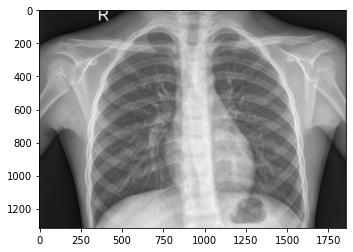

In [5]:
norm_image = Image.open('/content/xray_dataset_covid19/train/NORMAL/IM-0001-0001.jpeg')
plt.imshow(norm_image, 'gray')

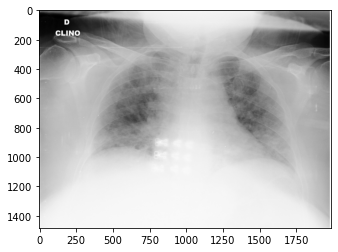

In [6]:
pneumonia_image = Image.open('/content/xray_dataset_covid19/train/PNEUMONIA/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg')
plt.imshow(pneumonia_image)

# Set Hyper Parameters & Model & Loss function & optimizer

In [13]:
import os 

os.makedirs("saved_models", exist_ok=True)

epochs = 20
batch_size = 16
lr = 0.001
sample_interval = 10

In [8]:
train_normal_list = glob('/content/xray_dataset_covid19/train/NORMAL/*.jpeg')
train_pneumonia_list = glob('/content/xray_dataset_covid19/train/PNEUMONIA/*.jpeg')

valid_normal_list = glob('/content/xray_dataset_covid19/test/NORMAL/*.jpeg')
valid_pneumonia_list = glob('/content/xray_dataset_covid19/test/PNEUMONIA/*.jpeg')

print(f'number of train images: {len(train_normal_list) + len(train_pneumonia_list)}')
print(f'number of valid images: {len(valid_normal_list) + len(valid_pneumonia_list)}')

number of train images: 115
number of valid images: 35


In [9]:
# noraml image : 0
# pneumonia image : 1
train_normal_labels = np.zeros((len(train_normal_list)))
train_pneumonia_labels = np.ones((len(train_pneumonia_list)))

valid_normal_labels = np.zeros((len(valid_normal_list)))
valid_pneumonia_labels = np.ones((len(valid_pneumonia_list)))

In [10]:
train_image_list = train_normal_list + train_pneumonia_list
train_labels = np.concatenate([train_normal_labels, train_pneumonia_labels], -1)
train_labels = np.expand_dims(train_labels, -1)

valid_image_list = valid_normal_list + valid_pneumonia_list
valid_labels = np.concatenate([valid_normal_labels, valid_pneumonia_labels], -1)
valid_labels = np.expand_dims(valid_labels, -1)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_dataset = Covid19Dataset(train_image_list, train_labels, transform)
val_dataset = Covid19Dataset(valid_image_list, valid_labels, transform)

for _ in range(9):
    train_dataset += Covid19Dataset(train_image_list, train_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet50().to(device)
summary(model, (1, 128, 128))
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 31, 31]           4,096
       BatchNorm2d-5           [-1, 64, 31, 31]             128
              ReLU-6           [-1, 64, 31, 31]               0
            Conv2d-7           [-1, 64, 31, 31]          36,864
       BatchNorm2d-8           [-1, 64, 31, 31]             128
              ReLU-9           [-1, 64, 31, 31]               0
           Conv2d-10          [-1, 256, 31, 31]          16,384
      BatchNorm2d-11          [-1, 256, 31, 31]             512
           Conv2d-12          [-1, 256, 31, 31]          16,384
      BatchNorm2d-13          [-1, 256, 31, 31]             512
       BottleNeck-14          [-1, 256,

# Training

In [15]:
start_time = time.time()

for epoch in range(1, epochs + 1):
    print('[Epoch %d/%d] - Trainig' %(epoch, epochs))
    model.train()
    for idx, (imgs, labels) in enumerate(train_loader):
        current_loss = 0.0
        current_correct = 0.0

        imgs, labels = imgs.to(device), labels.type(torch.FloatTensor).to(device)
       
        optimizer.zero_grad()

        outputs = model(imgs)
        preds = (outputs >= 0.5).type(torch.DoubleTensor).to(device)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item() 
        current_correct += torch.sum(preds == labels.data) 

        if (idx + 1) % sample_interval == 0:
            print('     [Batch %d/%d] Train Loss: %f  Train Accuracy: %f [Time elapsed (seconds): %f]' %
                  (idx + 1, len(train_loader), current_loss / batch_size, current_correct / batch_size, time.time() - start_time))
            # Save model checkpoints
            torch.save(model.state_dict(), "saved_models/%d_latest.pth" % epoch)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0.0
    print('[Epoch %d/%d] - Validation' %(epoch, epochs))
    for val_idx, (val_imgs, val_labels) in enumerate(val_loader):

        val_imgs, val_labels = val_imgs.to(device), val_labels.type(torch.FloatTensor).to(device)
       
        val_outputs = model(val_imgs)
        val_preds = (val_outputs >= 0.5).type(torch.DoubleTensor).to(device)
    
        val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
        val_correct += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]

    print('Val Loss: %f  Val Accuracy: %f [Time elapsed (seconds): %f]' %
                  (val_loss / len(val_loader), val_correct / len(val_loader), time.time() - start_time))

[Epoch 1/20] - Trainig
     [Batch 10/72] Train Loss: 0.008006  Train Accuracy: 1.000000 [Time elapsed (seconds): 5.840128]
     [Batch 20/72] Train Loss: 0.000310  Train Accuracy: 1.000000 [Time elapsed (seconds): 11.882789]
     [Batch 30/72] Train Loss: 0.001321  Train Accuracy: 1.000000 [Time elapsed (seconds): 17.725956]
     [Batch 40/72] Train Loss: 0.000594  Train Accuracy: 1.000000 [Time elapsed (seconds): 23.449243]
     [Batch 50/72] Train Loss: 0.000436  Train Accuracy: 1.000000 [Time elapsed (seconds): 28.662591]
     [Batch 60/72] Train Loss: 0.005830  Train Accuracy: 1.000000 [Time elapsed (seconds): 35.242250]
     [Batch 70/72] Train Loss: 0.001217  Train Accuracy: 1.000000 [Time elapsed (seconds): 41.287183]
[Epoch 1/20] - Validation
Val Loss: 0.005004  Val Accuracy: 0.979167 [Time elapsed (seconds): 43.662061]
[Epoch 2/20] - Trainig
     [Batch 10/72] Train Loss: 0.008043  Train Accuracy: 0.937500 [Time elapsed (seconds): 48.025130]
     [Batch 20/72] Train Loss: 0.0

# Test

In [27]:
test_normal_image = Image.open('/content/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg')
test_pneumonia_iamge = Image.open('/content/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg')

model.eval()
test_normal_image = transform(test_normal_image)
test_normal_image = test_normal_image.unsqueeze(1).to(device)

test_pneumonia_iamge = transform(test_pneumonia_iamge)
test_pneumonia_iamge = test_pneumonia_iamge.unsqueeze(1).to(device)

test_noraml_output = model(test_normal_image)
test_pneumonia_output = model(test_pneumonia_iamge)

test_noraml_pred = (test_noraml_output >= 0.5).type(torch.DoubleTensor)
test_pneumonia_pred = (test_pneumonia_output >= 0.5).type(torch.DoubleTensor)

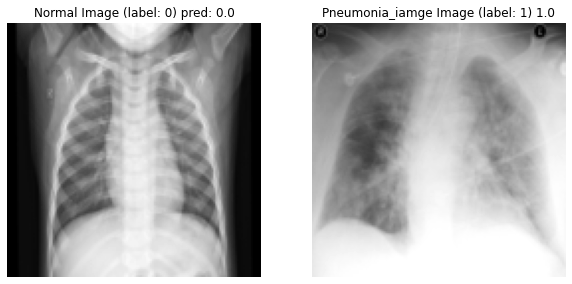

In [38]:
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(test_normal_image[0][0].detach().cpu().numpy(), 'gray')
plt.title(f'Normal Image (label: 0) pred: {test_noraml_pred.detach().cpu().numpy()[0][0]}')
plt.axis('off')

plt.subplot(122)
plt.imshow(test_pneumonia_iamge[0][0].detach().cpu().numpy(), 'gray')
plt.title(f'Pneumonia_iamge Image (label: 1) {test_pneumonia_pred.detach().cpu().numpy()[0][0]}')
plt.axis('off')
plt.show()